In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

In [9]:
from sklearn.decomposition import PCA

# Simulate Best Fit Network For Combo of Vision, Laser

In [3]:
id = (133, 0)
with open('./../results/results_ring_'+str(id[0])+'.pkl', 'rb') as handle:
    res_dict = pickle.load(handle)[id[1]]
    prms = res_dict['prms']
    eX = res_dict['best_monk_eX']
    bX = res_dict['best_monk_bX']
    aXs = res_dict['best_monk_aXs']
#     K = prms['K']
    SoriE = prms['SoriE']
    SoriI = prms['SoriI']
    SoriF = prms['SoriF']
#     J = prms['J']
#     beta = prms['beta']
#     gE = prms['gE']
#     gI = prms['gI']
#     hE = prms['hE']
#     hI = prms['hI']
#     L = prms['L']
#     CVL = prms['CVL']

ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')
ri.set_up_nonlinearity_tensor()

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/3
T = torch.linspace(0,4*Nt,round(4*Nt/dt)+1)
mask_time = T>(2*Nt)
T_mask = T.cpu().numpy()[mask_time][2::3]

N = 10000
Nori = 20
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

this_prms = prms.copy()
this_prms['Nori'] = Nori
this_prms['NE'] = NE
this_prms['NI'] = NI

Loading previously saved nonlinearity
Using cpu


In [5]:
reload(su)

start = time.process_time()

net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor([0],this_prms,eX)

dynas = np.zeros((2,2,N,len(T_mask)))

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,(bX*B+0.0*H)*eps,LAS,net.C_conds[0],mult_tau=True)
dynas[0,0,:,:] = sol[:,mask_time].cpu().numpy()[:,2::3]

print("Integrating spontaneous network took ",time.process_time() - start," s")
print('')

start = time.process_time()

sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,(bX*B+aXs[-1]*H)*eps,LAS,net.C_conds[0],mult_tau=True)
dynas[0,1,:,:] = sol[:,mask_time].cpu().numpy()[:,2::3]

print("Integrating visual only network took ",time.process_time() - start," s")
print('')

start = time.process_time()

sol,_ = integ.sim_dyn_tensor(ri,T,1.0,M,(bX*B+0.0*H)*eps,LAS,net.C_conds[0],mult_tau=True)
dynas[1,0,:,:] = sol[:,mask_time].cpu().numpy()[:,2::3]

print("Integrating laser only network took ",time.process_time() - start," s")
print('')

start = time.process_time()

sol,_ = integ.sim_dyn_tensor(ri,T,1.0,M,(bX*B+aXs[-1]*H)*eps,LAS,net.C_conds[0],mult_tau=True)
dynas[1,1,:,:] = sol[:,mask_time].cpu().numpy()[:,2::3]

print("Integrating visual + laser network took ",time.process_time() - start," s")
print('')

Using cpu
Generating disorder took  8.703767  s

Integrating spontaneous network took  223.75594600000002  s

Integrating visual only network took  406.85409200000004  s

Integrating laser only network took  196.5795270000001  s

Integrating visual + laser network took  420.02609699999994  s



# Perform PCA on Peak Rates

In [81]:
peak_rates = dynas[:,:,net.C_idxs[0][0],:]

In [59]:
X[len(X)//4:,:].shape

(600, 400)

In [67]:
np.tile(X[:len(X)//4,:],(3,1)).shape

(600, 400)

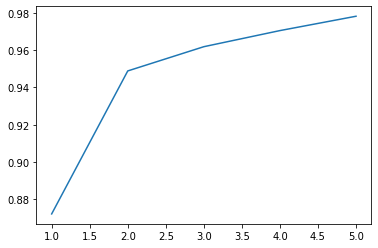

In [82]:
X = peak_rates.transpose((0,1,3,2)).reshape((-1,NE))
# X = X[len(X)//4:,:] - np.tile(X[:len(X)//4,:],(3,1))
pca = PCA(n_components=5)
pca.fit(X)
plt.plot(np.arange(1,5+1),np.cumsum(pca.explained_variance_ratio_))

In [83]:
pca_peak_rates = pca.transform(peak_rates.transpose((0,1,3,2)).reshape((-1,NE))).reshape((2,2,len(T_mask),-1))
pca_peak_rates -= pca_peak_rates[0,0,:,:][None,None,:,:]

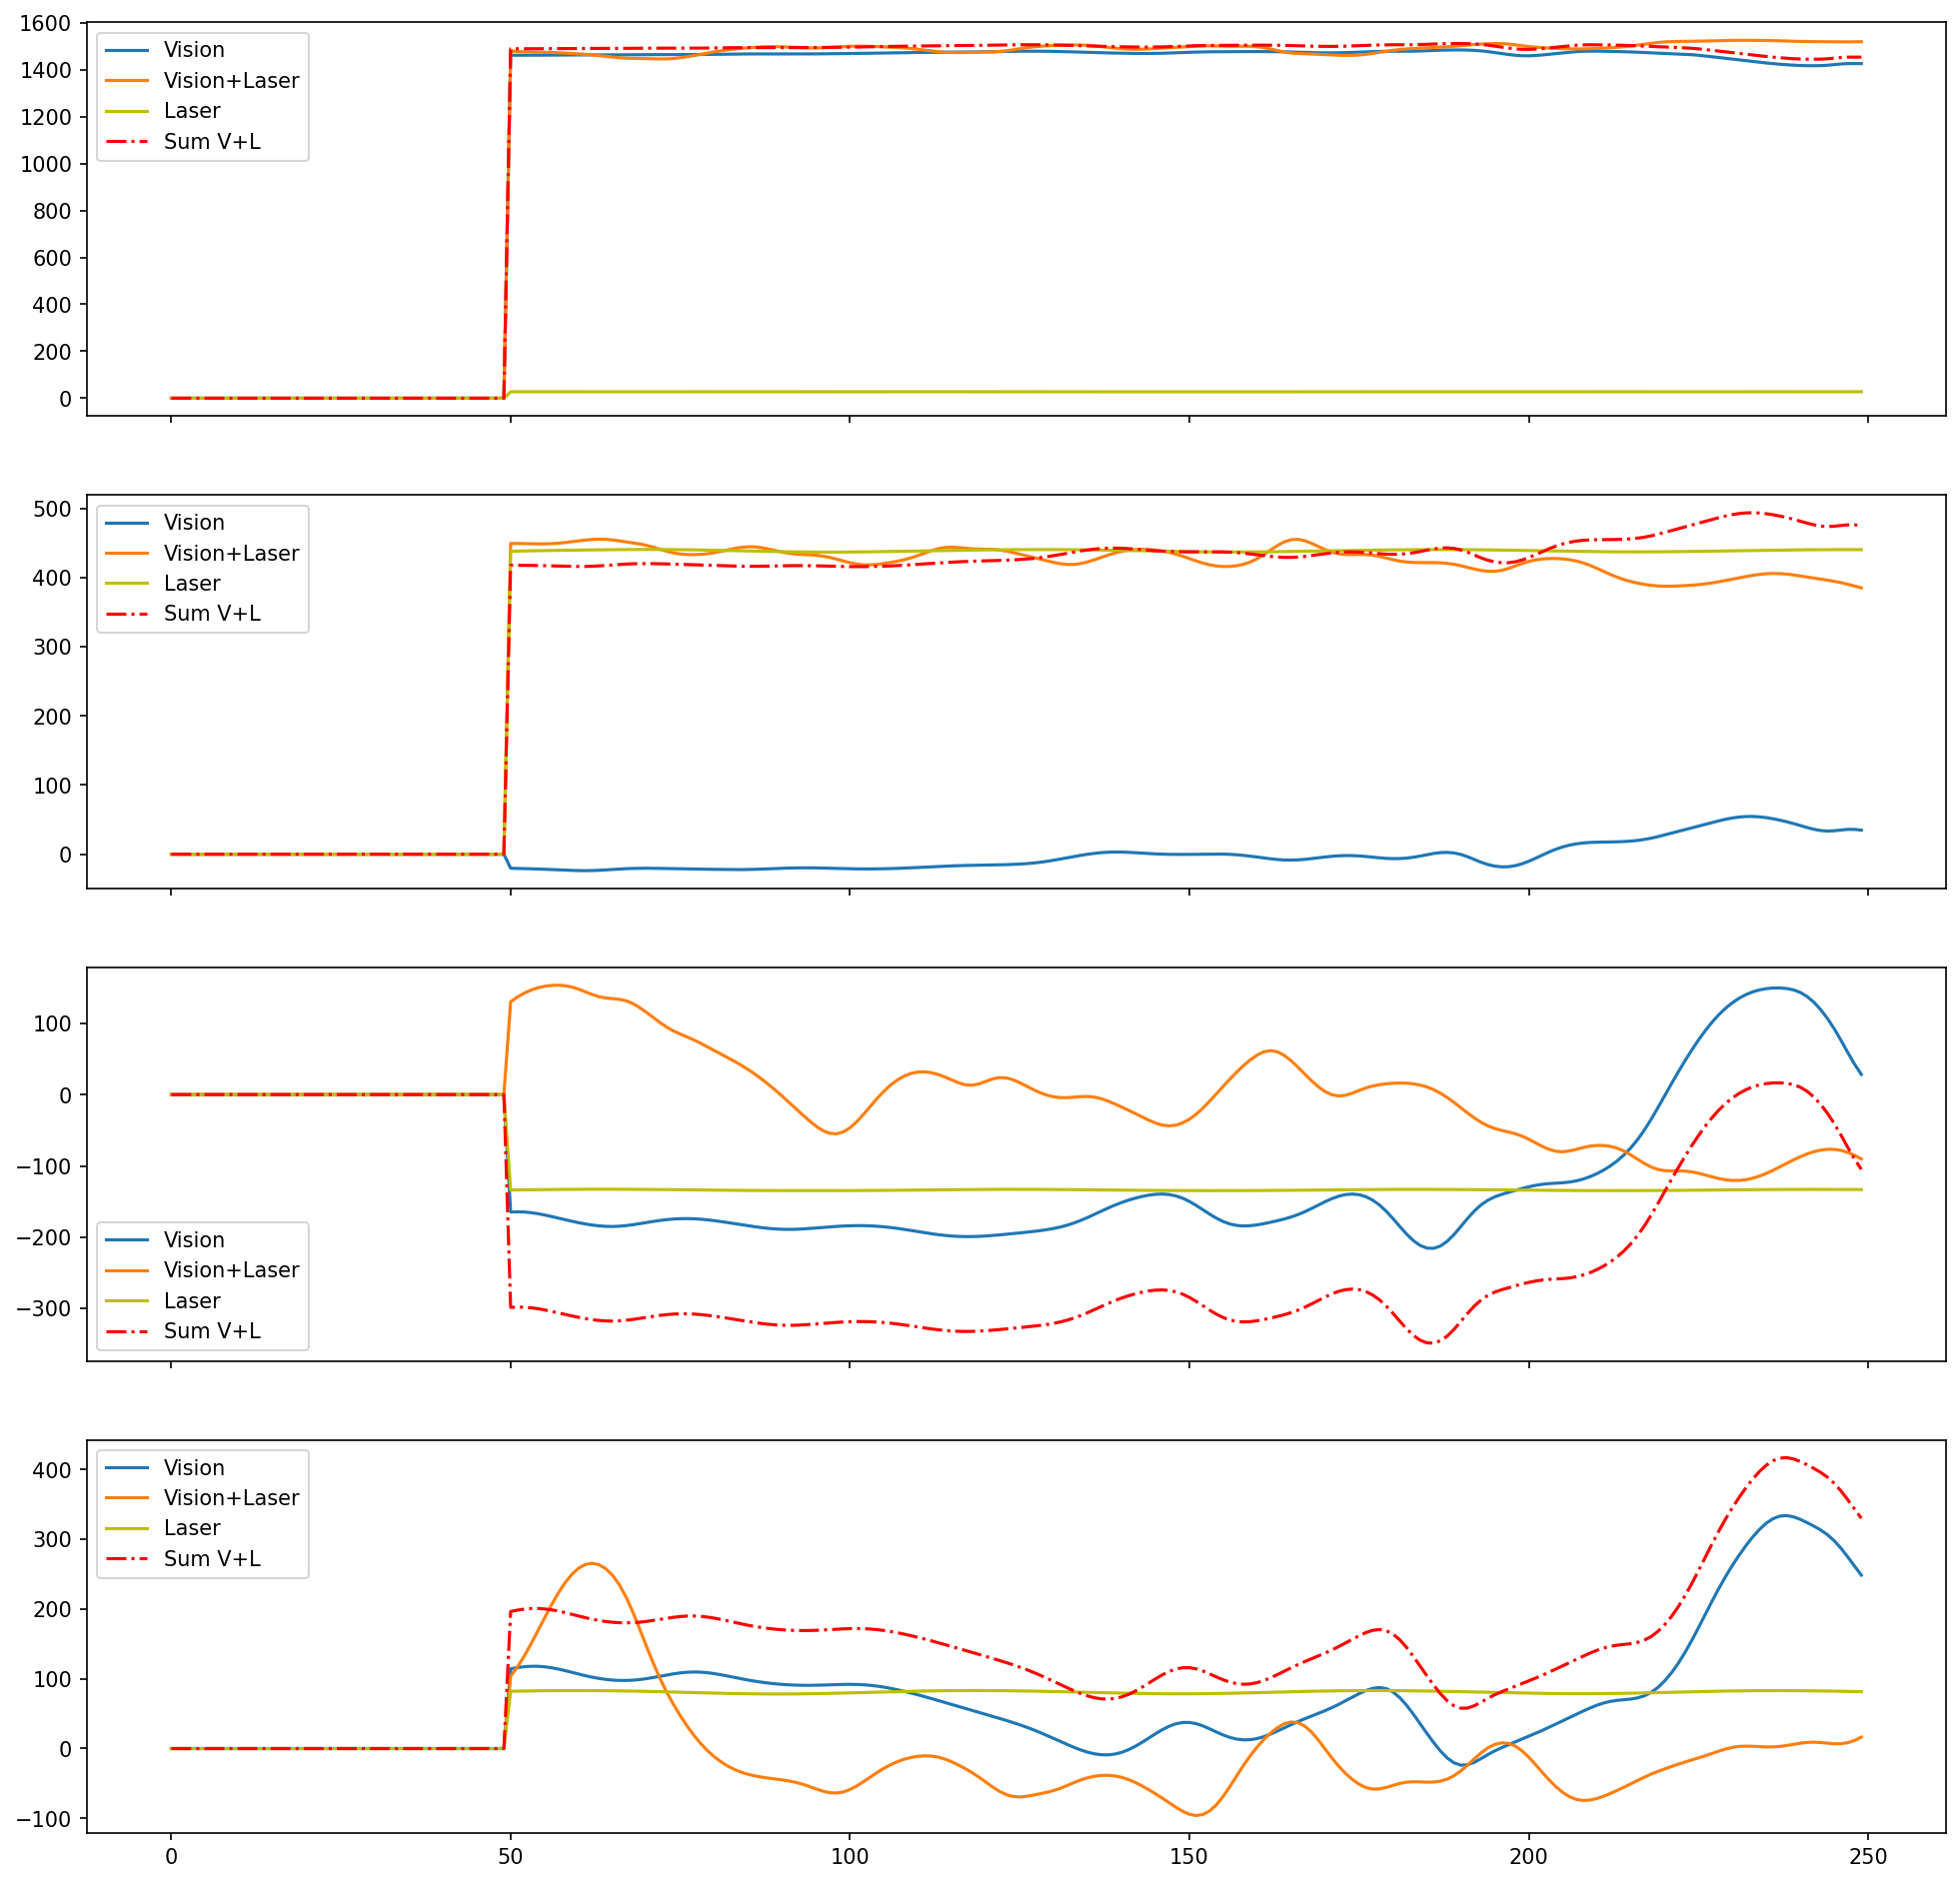

In [84]:
fig,axs = plt.subplots(4,1,figsize=(16,16),dpi=150,sharex=True)

for i in range(4):
    axs[i].plot(np.concatenate((pca_peak_rates[0,0,len(T_mask)*3//4:,i],
                                pca_peak_rates[0,1,:,i])),label='Vision')
    axs[i].plot(np.concatenate((pca_peak_rates[0,0,len(T_mask)*3//4:,i],
                                pca_peak_rates[1,1,:,i])),label='Vision+Laser')
    axs[i].plot(np.concatenate((pca_peak_rates[0,0,len(T_mask)*3//4:,i],
                                pca_peak_rates[1,0,:,i])),'y',label='Laser')
    axs[i].plot(np.concatenate((pca_peak_rates[0,0,len(T_mask)*3//4:,i],
                                pca_peak_rates[0,1,:,i]+pca_peak_rates[1,0,:,i])),'r-.',label='Sum V+L')
    axs[i].legend()